In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import pandas as pd
import os
from datetime import datetime

import numpy as np
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.utils import shuffle
#from keras.models import Sequential, Model
#from keras.layers import Dense, Dropout, BatchNormalization, Activation, Conv2D, MaxPooling2D, Flatten, ConvLSTM2D, MaxPooling3D, Reshape, LSTM
from keras.optimizers import *
#from keras.callbacks import EarlyStopping
#from keras.utils.np_utils import to_categorical
#from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation, MaxPooling2D, Flatten, MaxPooling3D, Reshape, LSTM
from tensorflow.keras.layers import ConvLSTM2D # problems with _long_ sequences: https://machinelearningmastery.com/prepare-univariate-time-series-data-long-short-term-memory-networks/
#from tensorflow.keras.utils import plot_model
# from tensorflow.keras.layers import Conv2D # different location in Keras
from tensorflow.keras.callbacks import History
from tensorflow.keras.callbacks import EarlyStopping
#from bayes_opt import BayesianOptimization
from bayesian_optimization import BayesianOptimization
from sklearn.model_selection import KFold
from timeit import timeit
from tensorflow.keras.utils import Sequence, plot_model
from tensorflow.keras.backend import sqrt, square, mean
import datetime
from sklearn.preprocessing import LabelEncoder
from collections import Counter
from matplotlib import pyplot
from imblearn.over_sampling import SMOTE

In [2]:
def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['accuracy'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

In [3]:
trainingDataRoot = '../TrainingData'
#trainingFileList = [f for f in os.listdir(trainingDataRoot) if f.endswith('.npy') and os.path.isfile(os.path.join(trainingDataRoot, f))]

In [5]:
trainingDataFolder = sorted( [ o for o in os.listdir( trainingDataRoot ) if os.path.isdir( os.path.join( trainingDataRoot, o ) )], reverse=False )
trainingDataFolder

['2003-11-24',
 '2005-11-08',
 '2007-12-20',
 '2009-07-15',
 '2010-09-03',
 '2011-01-27',
 '2011-02-21',
 '2011-06-13',
 '2011-12-23',
 '2012-07-03',
 '2012-12-07',
 '2013-07-18',
 '2013-08-16',
 '2014-01-20',
 '2015-01-05',
 '2015-04-24',
 '2015-10-12',
 '2016-02-09',
 '2016-02-14',
 '2016-11-13',
 '2016-11-22',
 '2016-12-04',
 '2016-12-29',
 '2018-10-30',
 '2019-06-08',
 '2019-10-01']

In [6]:
trainingFileList = []
for i in trainingDataFolder:
  dayList = []
  for o in sorted( os.listdir(os.path.join(trainingDataRoot, i)) ):
    if o.endswith('.npy') and os.path.isfile( os.path.join( trainingDataRoot, i, o ) ):
      dayList.append(o)
  trainingFileList.append(dayList)
trainingFileList

[['2003-11-03.npy',
  '2003-11-04.npy',
  '2003-11-05.npy',
  '2003-11-06.npy',
  '2003-11-07.npy',
  '2003-11-08.npy',
  '2003-11-09.npy',
  '2003-11-10.npy',
  '2003-11-11.npy',
  '2003-11-12.npy',
  '2003-11-13.npy',
  '2003-11-14.npy',
  '2003-11-15.npy',
  '2003-11-16.npy',
  '2003-11-17.npy',
  '2003-11-18.npy',
  '2003-11-19.npy',
  '2003-11-20.npy',
  '2003-11-21.npy',
  '2003-11-22.npy',
  '2003-11-23.npy',
  '2003-11-24.npy',
  '2003-11-25.npy',
  '2003-11-26.npy'],
 ['2005-10-18.npy',
  '2005-10-19.npy',
  '2005-10-20.npy',
  '2005-10-21.npy',
  '2005-10-22.npy',
  '2005-10-23.npy',
  '2005-10-24.npy',
  '2005-10-25.npy',
  '2005-10-26.npy',
  '2005-10-27.npy',
  '2005-10-28.npy',
  '2005-10-29.npy',
  '2005-10-30.npy',
  '2005-10-31.npy',
  '2005-11-01.npy',
  '2005-11-02.npy',
  '2005-11-03.npy',
  '2005-11-04.npy',
  '2005-11-05.npy',
  '2005-11-06.npy',
  '2005-11-07.npy',
  '2005-11-08.npy',
  '2005-11-09.npy',
  '2005-11-10.npy'],
 ['2007-11-29.npy',
  '2007-11-30.npy'

In [10]:
oneDayList = []
for i in trainingDataFolder:
    oneDay = datetime.datetime.strptime( i, '%Y-%m-%d' ) + datetime.timedelta( days=-1 )
    oneDaystr = '{:04}-{:02}-{:02}'.format( oneDay.year, oneDay.month, oneDay.day )
    oneDayList.append(oneDaystr)
oneDayList

['2003-11-23',
 '2005-11-07',
 '2007-12-19',
 '2009-07-14',
 '2010-09-02',
 '2011-01-26',
 '2011-02-20',
 '2011-06-12',
 '2011-12-22',
 '2012-07-02',
 '2012-12-06',
 '2013-07-17',
 '2013-08-15',
 '2014-01-19',
 '2015-01-04',
 '2015-04-23',
 '2015-10-11',
 '2016-02-08',
 '2016-02-13',
 '2016-11-12',
 '2016-11-21',
 '2016-12-03',
 '2016-12-28',
 '2018-10-29',
 '2019-06-07',
 '2019-09-30']

In [9]:
twoDayList = []
for i in trainingDataFolder:
    twoDay = datetime.datetime.strptime( i, '%Y-%m-%d' ) + datetime.timedelta( days=-2 )
    twoDaystr = '{:04}-{:02}-{:02}'.format( twoDay.year, twoDay.month, twoDay.day )
    twoDayList.append(twoDaystr)
twoDayList

['2003-11-22',
 '2005-11-06',
 '2007-12-18',
 '2009-07-13',
 '2010-09-01',
 '2011-01-25',
 '2011-02-19',
 '2011-06-11',
 '2011-12-21',
 '2012-07-01',
 '2012-12-05',
 '2013-07-16',
 '2013-08-14',
 '2014-01-18',
 '2015-01-03',
 '2015-04-22',
 '2015-10-10',
 '2016-02-07',
 '2016-02-12',
 '2016-11-11',
 '2016-11-20',
 '2016-12-02',
 '2016-12-27',
 '2018-10-28',
 '2019-06-06',
 '2019-09-29']

In [97]:
trainingData = []
trainingLabel = []
for i, j in enumerate( trainingDataFolder ):
  for m in range( len( trainingFileList[i] ) - 9 ):
    sequenceData = []
    validateData = []
    for n in range ( 10 ):
      with open( os.path.join(trainingDataRoot, j, trainingFileList[i][m +n] ), 'rb' ) as f:
        sequenceData.append( list( np.load( f ) ) )
        validateData.append(os.path.splitext( trainingFileList[i][m +n] )[0] )
        #print( f'validateData:{validateData} {i, m +n}' )
    trainingData.append( sequenceData )
    if validateData[-1] in trainingDataFolder:
      trainingLabel.append( 0.4 )
    elif validateData[-1] in oneDayList or validateData[-2] in trainingDataFolder:
      trainingLabel.append( 0.25 )
    elif validateData[-1] in twoDayList or validateData[-3] in trainingDataFolder:
      trainingLabel.append( 0.05 )
    else:
      trainingLabel.append(0)
train_X = np.array( trainingData, dtype=np.float32 )
print( train_X.shape )
train_y = np.array( trainingLabel, dtype=np.float32 )
print( train_y.shape )

(390, 10, 50, 50, 3)
(390,)


In [98]:
train_y

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05,
       0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25,
       0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 ,
       0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25,
       0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.

In [99]:
testDataRoot = '../TestData'
#testFileList = [f for f in os.listdir(testDataRoot) if f.endswith('.npy') and os.path.isfile(os.path.join(testDataRoot, f))]

In [100]:
testDataFolder = sorted( [ o for o in os.listdir( testDataRoot ) if os.path.isdir( os.path.join( testDataRoot, o ) )], reverse=False )
testDataFolder

['2013-12-16', '2015-05-04', '2017-10-22']

In [101]:
testFileList = []
for i in testDataFolder:
  dayList = []
  for o in sorted( os.listdir( os.path.join(testDataRoot, i ) ) ):
    if o.endswith( '.npy' ) and os.path.isfile( os.path.join( testDataRoot, i, o ) ):
      dayList.append( o )
  testFileList.append( dayList )
testFileList

[['2013-11-25.npy',
  '2013-11-26.npy',
  '2013-11-27.npy',
  '2013-11-28.npy',
  '2013-11-29.npy',
  '2013-11-30.npy',
  '2013-12-01.npy',
  '2013-12-02.npy',
  '2013-12-03.npy',
  '2013-12-04.npy',
  '2013-12-05.npy',
  '2013-12-06.npy',
  '2013-12-07.npy',
  '2013-12-08.npy',
  '2013-12-09.npy',
  '2013-12-10.npy',
  '2013-12-11.npy',
  '2013-12-12.npy',
  '2013-12-13.npy',
  '2013-12-14.npy',
  '2013-12-15.npy',
  '2013-12-16.npy',
  '2013-12-17.npy',
  '2013-12-18.npy'],
 ['2015-04-13.npy',
  '2015-04-14.npy',
  '2015-04-15.npy',
  '2015-04-16.npy',
  '2015-04-17.npy',
  '2015-04-18.npy',
  '2015-04-19.npy',
  '2015-04-20.npy',
  '2015-04-21.npy',
  '2015-04-22.npy',
  '2015-04-23.npy',
  '2015-04-24.npy',
  '2015-04-25.npy',
  '2015-04-26.npy',
  '2015-04-27.npy',
  '2015-04-28.npy',
  '2015-04-29.npy',
  '2015-04-30.npy',
  '2015-05-01.npy',
  '2015-05-02.npy',
  '2015-05-03.npy',
  '2015-05-04.npy',
  '2015-05-05.npy',
  '2015-05-06.npy'],
 ['2017-10-01.npy',
  '2017-10-02.npy'

In [102]:
testData = []
testLabel = []
for i, j in enumerate( testDataFolder ):
  for m in range( len( testFileList[i] ) - 9 ):
    sequenceData = []
    validateData = []
    for n in range ( 10 ):
      with open( os.path.join( testDataRoot, j, testFileList[i][m +n] ), 'rb') as f:
        sequenceData.append( list( np.load( f ) ) )
        validateData.append( os.path.splitext( testFileList[i][m +n] )[0] )
        #print( f'validateData:{validateData} {i, m +n}' )
    testData.append( sequenceData )
    twoDay = datetime.datetime.strptime( j, '%Y-%m-%d' ) + datetime.timedelta( days=-2 )
    twoDaystr = '{:04}-{:02}-{:02}'.format( twoDay.year, twoDay.month, twoDay.day )
    oneDay = datetime.datetime.strptime( j, '%Y-%m-%d' ) + datetime.timedelta( days=-1 )
    oneDaystr = '{:04}-{:02}-{:02}'.format( oneDay.year, oneDay.month, oneDay.day )
    if validateData[-1] == j:
      testLabel.append( 0.4 )
    elif validateData[-1] == twoDaystr or validateData[-3] == j:
      testLabel.append( 0.05 )
    elif validateData[-1] == oneDaystr or validateData[-2] == j:
      testLabel.append( 0.25 )
    else:
      testLabel.append(0)
test_X = np.array( testData, dtype=np.float32 )
print( test_X.shape )
test_y = np.array( testLabel, dtype=np.float32 )
print( test_y.shape )

(45, 10, 50, 50, 3)
(45,)


In [103]:
test_y

array([0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05,
       0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25, 0.05, 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.05, 0.25, 0.4 , 0.25,
       0.05], dtype=float32)

Class=0, n=248 (63.590%)
Class=1, n=56 (14.359%)
Class=2, n=57 (14.615%)
Class=3, n=29 (7.436%)


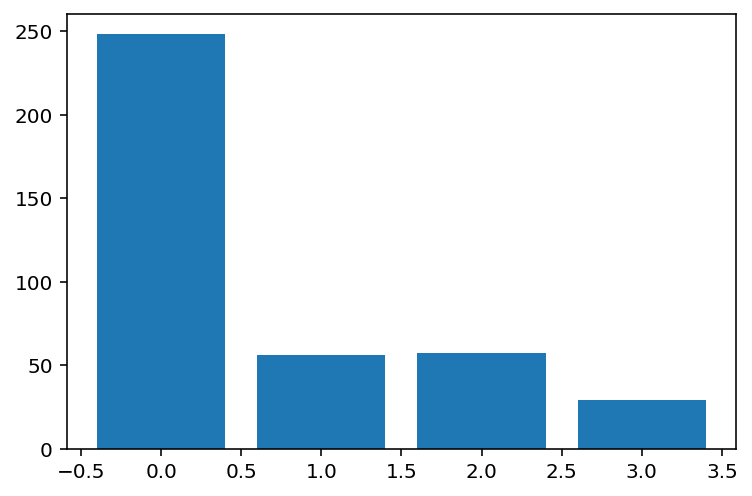

In [104]:
# label encode the target variable
y = LabelEncoder().fit_transform(train_y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [105]:
orig_shape = train_X.shape
print(orig_shape)

(390, 10, 50, 50, 3)


In [106]:
train2D_X = np.reshape(train_X, (train_X.shape[0], train_X.shape[1] * train_X.shape[2] * train_X.shape[3] * train_X.shape[4]))
print(train2D_X.shape)

(390, 75000)


Class=0, n=248 (25.000%)
Class=1, n=248 (25.000%)
Class=2, n=248 (25.000%)
Class=3, n=248 (25.000%)


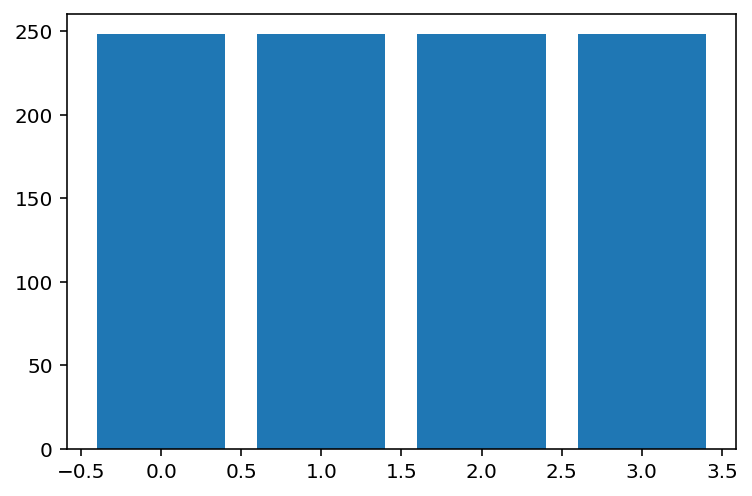

In [107]:
from imblearn.over_sampling import SMOTE
# label encode the target variable
y = LabelEncoder().fit_transform(train_y)
# transform the dataset
oversample = SMOTE()
new_train_X, new_train_y = oversample.fit_resample(train2D_X, y)
# summarize distribution
counter = Counter(new_train_y)
for k,v in counter.items():
    per = v / len(new_train_y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

In [108]:
new_train_y = new_train_y.astype(np.float)
for i in range(len(new_train_y)):
    if new_train_y[i] == 1:
        new_train_y[i] = 0.05
    if new_train_y[i] == 2:
        new_train_y[i] = 0.25
    if new_train_y[i] == 3:
        new_train_y[i] = 0.4

In [109]:
new_shape = (new_train_X.shape[0], train_X.shape[1], train_X.shape[2], train_X.shape[3], train_X.shape[4])
new_train_X = np.reshape(new_train_X, new_shape)
print(new_train_X.shape)

(992, 10, 50, 50, 3)


In [110]:
training_image_size = ( train_X.shape[1], train_X.shape[2], train_X.shape[3], train_X.shape[4] )
print( training_image_size )

(10, 50, 50, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


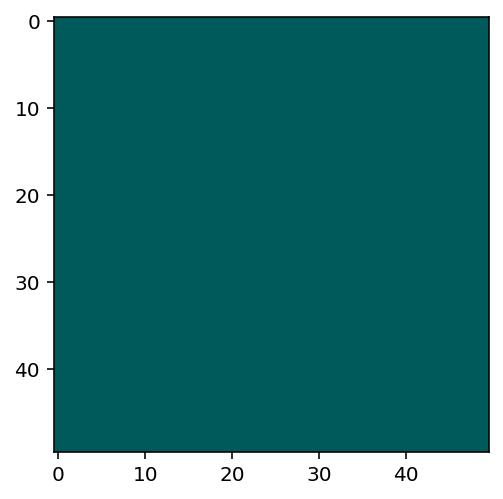

In [111]:
plt.imshow(train_X[0][0])

In [112]:
#from sklearn.utils import shuffle
new_train_X, new_train_y = shuffle(new_train_X, new_train_y)

In [113]:
new_train_y

array([0.4 , 0.05, 0.05, 0.  , 0.4 , 0.05, 0.  , 0.25, 0.4 , 0.  , 0.25,
       0.25, 0.05, 0.4 , 0.4 , 0.  , 0.05, 0.  , 0.4 , 0.25, 0.25, 0.05,
       0.  , 0.05, 0.05, 0.4 , 0.4 , 0.05, 0.  , 0.25, 0.  , 0.4 , 0.4 ,
       0.4 , 0.05, 0.05, 0.  , 0.  , 0.05, 0.05, 0.  , 0.4 , 0.25, 0.4 ,
       0.25, 0.25, 0.05, 0.  , 0.  , 0.25, 0.4 , 0.4 , 0.4 , 0.  , 0.4 ,
       0.  , 0.  , 0.  , 0.  , 0.05, 0.05, 0.05, 0.05, 0.25, 0.25, 0.4 ,
       0.4 , 0.4 , 0.25, 0.4 , 0.  , 0.25, 0.4 , 0.05, 0.4 , 0.4 , 0.25,
       0.25, 0.05, 0.  , 0.25, 0.05, 0.05, 0.  , 0.4 , 0.05, 0.4 , 0.05,
       0.  , 0.05, 0.  , 0.4 , 0.  , 0.4 , 0.  , 0.  , 0.  , 0.4 , 0.4 ,
       0.4 , 0.05, 0.25, 0.05, 0.05, 0.  , 0.05, 0.05, 0.05, 0.4 , 0.25,
       0.4 , 0.05, 0.05, 0.  , 0.25, 0.  , 0.25, 0.  , 0.05, 0.  , 0.05,
       0.4 , 0.25, 0.4 , 0.25, 0.  , 0.05, 0.  , 0.4 , 0.  , 0.25, 0.  ,
       0.25, 0.05, 0.  , 0.25, 0.4 , 0.  , 0.4 , 0.25, 0.05, 0.  , 0.  ,
       0.25, 0.05, 0.4 , 0.4 , 0.05, 0.25, 0.05, 0.

In [86]:
neuronsLevel = 32
neuronsLevel*= 2
neuronsLevel

64

In [114]:
def build_convnet( neurons=32, kernels=4, layers=2, shrink=2):
  model = Sequential()
  neurons = int( neurons )
  kernels = int( kernels )
  layers = int( layers )
  fred = int( kernels *2 +1 )
  neuronsLevel = neurons
  model.add(ConvLSTM2D( neuronsLevel, (fred, fred), name='base',activation='relu', padding='same', return_sequences=True, input_shape = training_image_size, kernel_initializer='glorot_uniform'))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))

  for i in range( layers ):
    neuronsLevel *= 2
    model.add(ConvLSTM2D( int(neuronsLevel), (fred, fred), name=f'myThing{i}', activation='relu', padding='same', return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  #for l in range( layers ):
    #model.add(ConvLSTM2D(neurons *32, (fred, fred), activation='relu', padding='same', return_sequences=True))
  #model.add(MaxPooling3D(pool_size=(1, 2, 2)))
  neuronsLevel *= shrink
  model.add(ConvLSTM2D(int(neuronsLevel), (fred, fred), activation='relu', padding='same', return_sequences=False))
  model.add(MaxPooling2D(pool_size=(1, 2)))
  model.add(Dense(320))
  model.add(Activation('relu'))
  model.add(Dropout(0.1))


  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dense(1, activation='relu'))


  #out_shape = model.output_shape
  #SequenceLength = train_X.shape[1]
  #model.add(Reshape((SequenceLength, out_shape[1])))
  #model.add(LSTM(64, return_sequences=False))
  #model.add(Dropout(0.5))
  #model.add(Dense(1, activation='relu'))
  model.compile(loss='mse', optimizer='sgd', metrics=['accuracy'])

  
 
  # model structure summary
  return model

model = build_convnet()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base (ConvLSTM2D)            (None, 10, 50, 50, 32)    363008    
_________________________________________________________________
max_pooling3d_3 (MaxPooling3 (None, 10, 25, 25, 32)    0         
_________________________________________________________________
myThing0 (ConvLSTM2D)        (None, 10, 25, 25, 64)    1990912   
_________________________________________________________________
myThing1 (ConvLSTM2D)        (None, 10, 25, 25, 128)   7963136   
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 10, 12, 12, 128)   0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, 12, 12, 256)       31851520  
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 6, 256)       

In [115]:
print(new_train_X.shape)
print(new_train_y.shape)
print(test_X.shape)
print(test_y.shape)

(992, 10, 50, 50, 3)
(992,)
(45, 10, 50, 50, 3)
(45,)


In [116]:
earlyStopping = EarlyStopping( monitor='val_loss', min_delta=1.0e-4, patience=5, verbose=2, mode='auto' )
callbacks = [earlyStopping]
history = model.fit(new_train_X, new_train_y, batch_size=4, epochs=100, verbose=True, validation_split=0.1, callbacks=callbacks, shuffle=False)
loss, accuracy  = model.evaluate(test_X, test_y, verbose=False)
model.predict( test_X ).max()

Epoch 1/100
223/223 [==============================] - 5934s 27s/step - loss: 0.0566 - accuracy: 0.2482 - val_loss: 0.0539 - val_accuracy: 0.2500
Epoch 2/100
223/223 [==============================] - 5907s 26s/step - loss: 0.0437 - accuracy: 0.2482 - val_loss: 0.0242 - val_accuracy: 0.2500
Epoch 3/100
223/223 [==============================] - 5353s 24s/step - loss: 0.0264 - accuracy: 0.2482 - val_loss: 0.0242 - val_accuracy: 0.2500
Epoch 4/100
223/223 [==============================] - 5366s 24s/step - loss: 0.0264 - accuracy: 0.2482 - val_loss: 0.0242 - val_accuracy: 0.2500
Epoch 5/100
223/223 [==============================] - 5631s 25s/step - loss: 0.0264 - accuracy: 0.2482 - val_loss: 0.0242 - val_accuracy: 0.2500
Epoch 6/100
223/223 [==============================] - 5343s 24s/step - loss: 0.0264 - accuracy: 0.2482 - val_loss: 0.0242 - val_accuracy: 0.2500
Epoch 7/100
223/223 [==============================] - 5337s 24s/step - loss: 0.0263 - accuracy: 0.2482 - val_loss: 0.0242 -

0.16561183

In [117]:
a = zip(model.predict( test_X ), test_y)
for i in a:
  print(i)

(array([0.16561183], dtype=float32), 0.0)
(array([0.16546367], dtype=float32), 0.0)
(array([0.16529188], dtype=float32), 0.0)
(array([0.16522959], dtype=float32), 0.0)
(array([0.16526054], dtype=float32), 0.0)
(array([0.16527964], dtype=float32), 0.0)
(array([0.16528574], dtype=float32), 0.0)
(array([0.16532879], dtype=float32), 0.0)
(array([0.16536653], dtype=float32), 0.0)
(array([0.16532221], dtype=float32), 0.0)
(array([0.16527544], dtype=float32), 0.05)
(array([0.1652001], dtype=float32), 0.25)
(array([0.16511247], dtype=float32), 0.4)
(array([0.16503191], dtype=float32), 0.25)
(array([0.16499515], dtype=float32), 0.05)
(array([0.16271263], dtype=float32), 0.0)
(array([0.16269714], dtype=float32), 0.0)
(array([0.16268533], dtype=float32), 0.0)
(array([0.16267209], dtype=float32), 0.0)
(array([0.16266593], dtype=float32), 0.0)
(array([0.1626696], dtype=float32), 0.0)
(array([0.16268998], dtype=float32), 0.0)
(array([0.16272126], dtype=float32), 0.0)
(array([0.16276258], dtype=float

In [1]:
plot_loss_accuracy(history)
print(f'Test loss: {loss:.3}')
print(f'Test accuracy: {accuracy:.3}')

NameError: name 'plot_loss_accuracy' is not defined

In [ ]:
history.history

{'accuracy': [0.6714285612106323,
  0.6714285612106323,
  0.6714285612106323,
  0.6714285612106323,
  0.6714285612106323,
  0.6714285612106323],
 'loss': [0.015060091391205788,
  0.015102903358638287,
  0.015099053271114826,
  0.0150075051933527,
  0.015055696479976177,
  0.015163478441536427],
 'val_accuracy': [0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816,
  0.6666666865348816],
 'val_loss': [0.014888928271830082,
  0.01488894410431385,
  0.014889311045408249,
  0.014888972043991089,
  0.014888884499669075,
  0.014889095909893513]}

In [23]:
def modelFit():
  earlyStopping = EarlyStopping( monitor='val_loss', min_delta=1.0e-4, patience=5, verbose=2, mode='auto' )
  callbacks = [earlyStopping]
  history = model.fit(train_X, train_y, batch_size=4, epochs=100, verbose=True, validation_data=( test_X, test_y ), callbacks=callbacks, shuffle=False)
  loss, accuracy  = model.evaluate(test_X, test_y, verbose=False)
  return model.predict( test_X ).max()

In [24]:
def modeltests( **kwargs ):
#  return math.sqrt( kwargs['layers']) *math.sin( kwargs['neurons'])
  model = build_convnet( **kwargs )
  if model:
    result = modelFit()
    return float(result)

In [27]:
pbounds = { 'layers': ( 0, 4 ), # number of "return_sequences=True" ConvLSTM layers
            'neurons': ( 1, 50 ), # all layers have this number of neurons (at present)
            'kernels': ( 1, 5 ), # int( kernel ) *2 +1 - odd numbers 3, 5, 7, 9, &c.
            'shrink': (1, 3)
          }
optimizer = BayesianOptimization(
                            f=modeltests,
                            pbounds=pbounds,
                            verbose=10,
                            random_state=42
                            )
optimizer.maximize( init_points=12, n_iter=8 )
optimizer.max

|   iter    |  target   |  kernels  |  layers   |  neurons  |  shrink   |
-------------------------------------------------------------------------
Epoch 1/100
57/57 [==============================] - 212s 4s/step - loss: 0.0179 - accuracy: 0.6835 - val_loss: 0.0151 - val_accuracy: 0.6667
Epoch 2/100
57/57 [==============================] - 201s 4s/step - loss: 0.0162 - accuracy: 0.6835 - val_loss: 0.0151 - val_accuracy: 0.6667
Epoch 3/100
57/57 [==============================] - 202s 4s/step - loss: 0.0162 - accuracy: 0.6835 - val_loss: 0.0151 - val_accuracy: 0.6667
Epoch 4/100
57/57 [==============================] - 204s 4s/step - loss: 0.0162 - accuracy: 0.6835 - val_loss: 0.0151 - val_accuracy: 0.6667
Epoch 5/100
57/57 [==============================] - 204s 4s/step - loss: 0.0162 - accuracy: 0.6835 - val_loss: 0.0151 - val_accuracy: 0.6667
Epoch 6/100
57/57 [==============================] - 203s 4s/step - loss: 0.0162 - accuracy: 0.6835 - val_loss: 0.0150 - val_accuracy: 0.6667


57/57 [==============================] - 211s 4s/step - loss: 0.0150 - accuracy: 0.6711 - val_loss: 0.0150 - val_accuracy: 0.6667
Epoch 2/100
57/57 [==============================] - 211s 4s/step - loss: 0.0150 - accuracy: 0.6711 - val_loss: 0.0150 - val_accuracy: 0.6667
Epoch 3/100
57/57 [==============================] - 212s 4s/step - loss: 0.0151 - accuracy: 0.6711 - val_loss: 0.0150 - val_accuracy: 0.6667
Epoch 4/100
57/57 [==============================] - 211s 4s/step - loss: 0.0150 - accuracy: 0.6711 - val_loss: 0.0150 - val_accuracy: 0.6667
Epoch 5/100
57/57 [==============================] - 212s 4s/step - loss: 0.0150 - accuracy: 0.6711 - val_loss: 0.0150 - val_accuracy: 0.6667
Epoch 6/100
57/57 [==============================] - 211s 4s/step - loss: 0.0150 - accuracy: 0.6711 - val_loss: 0.0150 - val_accuracy: 0.6667
Epoch 00006: early stopping
|  9        |  0.05492  |  1.26     |  3.796    |  48.32    |  2.617    |
Epoch 1/100
57/57 [==============================] - 211s 

{'target': 0.055646516382694244,
 'params': {'kernels': 4.942993803924221,
  'layers': 2.55841474322518,
  'neurons': 32.29901153587193,
  'shrink': 1.9550955943743022}}

In [ ]:
def printModel( model, filename ):
    try:
        print( model.summary())
            plot_model( model, to_file=filename, show_shapes=True )
    except ValueError as ex:
        print( '\nUnable to print model summary:{}\n'.format( ex ))
        return
    except ImportError as ex:
        print( '\nUnable  to print model:{}\n'.format( ex ))

In [ ]:
printModel(model, 'fred.png')

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
base (ConvLSTM2D)            (None, 10, 50, 50, 32)    363008    
_________________________________________________________________
max_pooling3d_30 (MaxPooling (None, 10, 25, 25, 32)    0         
_________________________________________________________________
myThing0 (ConvLSTM2D)        (None, 10, 25, 25, 2)     22040     
_________________________________________________________________
max_pooling3d_31 (MaxPooling (None, 10, 12, 12, 2)     0         
_________________________________________________________________
myThing1 (ConvLSTM2D)        (None, 10, 12, 12, 2)     2600      
_________________________________________________________________
max_pooling3d_32 (MaxPooling (None, 10, 6, 6, 2)       0         
_________________________________________________________________
conv_lst_m2d_43 (ConvLSTM2D) (None, 6, 6, 2)          